## Imports and functions

In [9]:
%%capture
!pip install SimpleITK
import numpy as np
import matplotlib.pyplot as plt
import SimpleITK as sitk
from IPython.display import clear_output
from skimage import color, io, measure, img_as_ubyte
from skimage.util import img_as_float, img_as_ubyte

In [10]:
def imshow_orthogonal_view(sitkImage, origin = None, title=None):
    """
    Display the orthogonal views of a 3D volume from the middle of the volume.

    Parameters
    ----------
    sitkImage : SimpleITK image
        Image to display.
    origin : array_like, optional
        Origin of the orthogonal views, represented by a point [x,y,z].
        If None, the middle of the volume is used.
    title : str, optional
        Super title of the figure.

    Note:
    On the axial and coronal views, patient's left is on the right
    On the sagittal view, patient's anterior is on the left
    """
    data = sitk.GetArrayFromImage(sitkImage)

    if origin is None:
        origin = np.array(data.shape) // 2

    fig, axes = plt.subplots(1, 3, figsize=(12, 4))

    data = img_as_ubyte(data/np.max(data))
    axes[0].imshow(data[origin[0], ::-1, ::-1], cmap='gray')
    axes[0].set_title('Axial')

    axes[1].imshow(data[::-1, origin[1], ::-1], cmap='gray')
    axes[1].set_title('Coronal')

    axes[2].imshow(data[::-1, ::-1, origin[2]], cmap='gray')
    axes[2].set_title('Sagittal')

    [ax.set_axis_off() for ax in axes]

    if title is not None:
        fig.suptitle(title, fontsize=16)

def overlay_slices(sitkImage0, sitkImage1, origin = None, title=None):
    """
    Overlay the orthogonal views of a two 3D volume from the middle of the volume.
    The two volumes must have the same shape. The first volume is displayed in red,
    the second in green.

    Parameters
    ----------
    sitkImage0 : SimpleITK image
        Image to display in red.
    sitkImage1 : SimpleITK image
        Image to display in green.
    origin : array_like, optional
        Origin of the orthogonal views, represented by a point [x,y,z].
        If None, the middle of the volume is used.
    title : str, optional
        Super title of the figure.

    Note:
    On the axial and coronal views, patient's left is on the right
    On the sagittal view, patient's anterior is on the left
    """
    vol0 = sitk.GetArrayFromImage(sitkImage0)
    vol1 = sitk.GetArrayFromImage(sitkImage1)

    if vol0.shape != vol1.shape:
        raise ValueError('The two volumes must have the same shape.')
    if np.min(vol0) < 0 or np.min(vol1) < 0: # Remove negative values - Relevant for the noisy images
        vol0[vol0 < 0] = 0
        vol1[vol1 < 0] = 0
    if origin is None:
        origin = np.array(vol0.shape) // 2

    sh = vol0.shape
    R = img_as_ubyte(vol0/np.max(vol0))
    G = img_as_ubyte(vol1/np.max(vol1))

    vol_rgb = np.zeros(shape=(sh[0], sh[1], sh[2], 3), dtype=np.uint8)
    vol_rgb[:, :, :, 0] = R
    vol_rgb[:, :, :, 1] = G

    fig, axes = plt.subplots(1, 3, figsize=(12, 4))

    axes[0].imshow(vol_rgb[origin[0], ::-1, ::-1, :])
    axes[0].set_title('Axial')

    axes[1].imshow(vol_rgb[::-1, origin[1], ::-1, :])
    axes[1].set_title('Coronal')

    axes[2].imshow(vol_rgb[::-1, ::-1, origin[2], :])
    axes[2].set_title('Sagittal')

    [ax.set_axis_off() for ax in axes]

    if title is not None:
        fig.suptitle(title, fontsize=16)
def composite2affine(composite_transform, result_center=None):
    """
    Combine all of the composite transformation's contents to form an equivalent affine transformation.
    Args:
        composite_transform (SimpleITK.CompositeTransform): Input composite transform which contains only
                                                            global transformations, possibly nested.
        result_center (tuple,list): The desired center parameter for the resulting affine transformation.
                                    If None, then set to [0,...]. This can be any arbitrary value, as it is
                                    possible to change the transform center without changing the transformation
                                    effect.
    Returns:
        SimpleITK.AffineTransform: Affine transformation that has the same effect as the input composite_transform.
    
    Source:
        https://github.com/InsightSoftwareConsortium/SimpleITK-Notebooks/blob/master/Python/22_Transforms.ipynb
    """
    # Flatten the copy of the composite transform, so no nested composites.
    flattened_composite_transform = sitk.CompositeTransform(composite_transform)
    flattened_composite_transform.FlattenTransform()
    tx_dim = flattened_composite_transform.GetDimension()
    A = np.eye(tx_dim)
    c = np.zeros(tx_dim) if result_center is None else result_center
    t = np.zeros(tx_dim)
    for i in range(flattened_composite_transform.GetNumberOfTransforms() - 1, -1, -1):
        curr_tx = flattened_composite_transform.GetNthTransform(i).Downcast()
        # The TranslationTransform interface is different from other
        # global transformations.
        if curr_tx.GetTransformEnum() == sitk.sitkTranslation:
            A_curr = np.eye(tx_dim)
            t_curr = np.asarray(curr_tx.GetOffset())
            c_curr = np.zeros(tx_dim)
        else:
            A_curr = np.asarray(curr_tx.GetMatrix()).reshape(tx_dim, tx_dim)
            c_curr = np.asarray(curr_tx.GetCenter())
            # Some global transformations do not have a translation
            # (e.g. ScaleTransform, VersorTransform)
            get_translation = getattr(curr_tx, "GetTranslation", None)
            if get_translation is not None:
                t_curr = np.asarray(get_translation())
            else:
                t_curr = np.zeros(tx_dim)
        A = np.dot(A_curr, A)
        t = np.dot(A_curr, t + c - c_curr) + t_curr + c_curr - c

    return sitk.AffineTransform(A.flatten(), t, c)
# Callback invoked when the StartEvent happens, sets up our new data.
def start_plot():
    global metric_values, multires_iterations
    
    metric_values = []
    multires_iterations = []

# Callback invoked when the EndEvent happens, do cleanup of data and figure.
def end_plot():
    global metric_values, multires_iterations
    
    del metric_values
    del multires_iterations
    # Close figure, we don't want to get a duplicate of the plot latter on.
    plt.close()

# Callback invoked when the IterationEvent happens, update our data and display new figure.
def plot_values(registration_method):
    global metric_values, multires_iterations
    
    metric_values.append(registration_method.GetMetricValue())                                       
    # Clear the output area (wait=True, to reduce flickering), and plot current data
    clear_output(wait=True)
    # Plot the similarity metric values
    plt.plot(metric_values, 'r')
    plt.plot(multires_iterations, [metric_values[index] for index in multires_iterations], 'b*')
    plt.xlabel('Iteration Number',fontsize=12)
    plt.ylabel('Metric Value',fontsize=12)
    plt.show()
    
# Callback invoked when the sitkMultiResolutionIterationEvent happens, update the index into the 
# metric_values list. 
def update_multires_iterations():
    global metric_values, multires_iterations
    multires_iterations.append(len(metric_values))

def command_iteration(method):
    print(
        f"{method.GetOptimizerIteration():3} "
        + f"= {method.GetMetricValue():10.5f} "
        + f": {method.GetOptimizerPosition()}"
    )

# 9 - Advanced 3D registration

## Image Registration

### Loading and 3D image and ortho view visualization
**Exercise 1:** Load the ImgT1.nii image and visualize its three ortho-views in one plot being the axial, sagittal, and coronal views

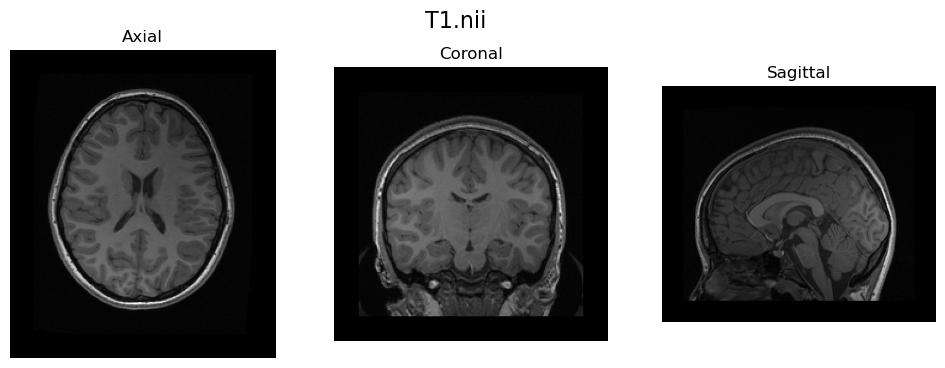

In [11]:
dir_in = 'data/'
vol_sitk = sitk.ReadImage(dir_in + 'ImgT1.nii')

# Display the volume
imshow_orthogonal_view(vol_sitk, title='T1.nii')

## Apply an affine transformation
**Exercise 2:** Write a function rotation_matrix(pitch, roll, yaw) which returns the rotation matrix for a given a roll, pitch, yaw. Make a 4x4 affine matrix with a pitch of 25 degrees.

In [12]:
def rotation_matrix(pitch, roll, yaw, deg = False):
    """
    Return the rotation matrix associated with the Euler angles roll, pitch, yaw.
    
    Parameters
    ----------
    pitch : float
        The rotation angle around the x-axis.
    roll : float
        The rotation angle around the y-axis.
    yaw : float
        The rotation angle around the z-axis.
    deg : bool, optional
        If True, the angles are given in degrees. If False, the angles are given
        in radians. Default: False.
    """
    if deg:
        roll = np.deg2rad(roll)
        pitch = np.deg2rad(pitch)
        yaw = np.deg2rad(yaw)

    R_x = np.array([[1, 0,             0,             0],
                    [0, np.cos(pitch),  -np.sin(pitch),  0],
                    [0, np.sin(pitch), np.cos(pitch),  0],
                    [0, 0,             0,             1]])

    R_y = np.array([[np.cos(roll), 0, np.sin(roll), 0],
                    [0, 1, 0, 0],
                    [-np.sin(roll), 0, np.cos(roll), 0],
                    [0, 0, 0, 1]])

    R_z = np.array([[np.cos(yaw),  -np.sin(yaw), 0, 0],
                    [np.sin(yaw), np.cos(yaw),  0, 0],
                    [0, 0, 1, 0],
                    [0, 0, 0, 1]])

    R = np.dot(np.dot(R_x, R_y), R_z)

    return R

In [75]:
m = rotation_matrix(25,0,0,deg=True)
m

array([[ 1.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.90630779, -0.42261826,  0.        ],
       [ 0.        ,  0.42261826,  0.90630779,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])

### Exercise 3
Apply the rotation to the ImgT1.nii around the central point of the volume and save the rotated images as ImgT1_A.nii. Note that the central point is given in physical units (mm) in the World Coordinate System

In [6]:
# Define the roll rotation in radians
angle = 25  # degrees
pitch_radians = np.deg2rad(angle)

# Create the Affine transform and set the rotation
transform = sitk.AffineTransform(3)

centre_image = np.array(vol_sitk.GetSize()) / 2 - 0.5 # Image Coordinate System
centre_world = vol_sitk.TransformContinuousIndexToPhysicalPoint(centre_image) # World Coordinate System
rot_matrix = rotation_matrix(pitch_radians, 0, 0)[:3, :3] # SimpleITK inputs the rotation and the translation separately

transform.SetCenter(centre_world) # Set the rotation centre
transform.SetMatrix(rot_matrix.T.flatten())

# Apply the transformation to the image
ImgT1_A = sitk.Resample(vol_sitk, transform)

# Save the rotated image
sitk.WriteImage(ImgT1_A, dir_in + 'ImgT1_A.nii')

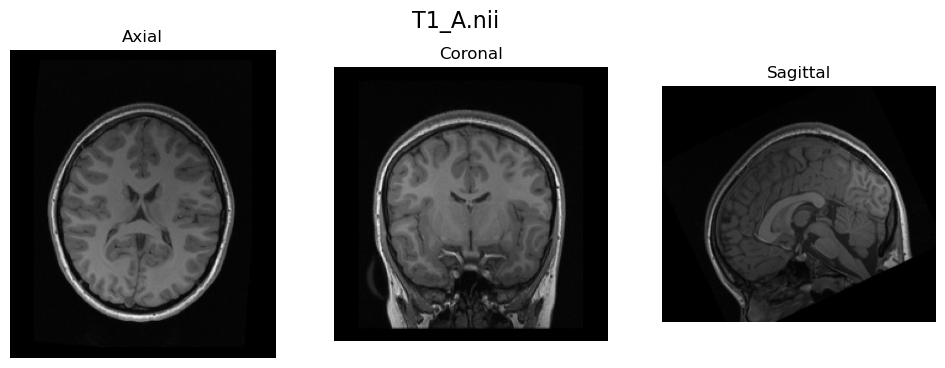

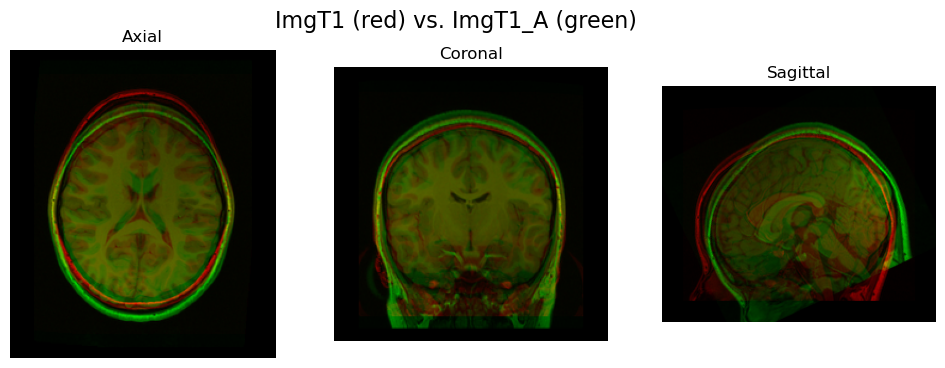

In [21]:
imshow_orthogonal_view(ImgT1_A, title='T1_A.nii')
overlay_slices(vol_sitk, ImgT1_A, title = 'ImgT1 (red) vs. ImgT1_A (green)')

## Registration of a moving image to a fixed image

### Exercise 5
Find the geometrical transformation of the moving image to the fixed image. The moving image is ImgT1_A.nii and the fixed image is ImgT1.nii. The new rotated image is named ImgT1_B.nii and the optimal affine transformation matrix text file is named A1.txt. You can try to modify the metric and optimizer step length.

In [13]:
fixed_image = sitk.ReadImage(dir_in + 'ImgT1.nii')
moving_image = sitk.ReadImage(dir_in + 'ImgT1_A.nii')

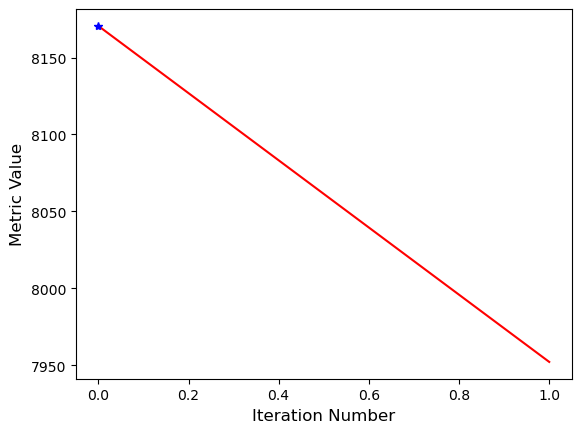

KeyboardInterrupt: 

RuntimeError: Exception thrown in SimpleITK ImageRegistrationMethod_Execute: D:\a\1\sitk\Wrapping\Python\sitkPyCommand.cxx:135:
sitk::ERROR: There was an error executing the Python Callable.

In [14]:
# Set the registration - Fig. 1 from the Theory Note
R = sitk.ImageRegistrationMethod()

# Set a one-level the pyramid scheule. [Pyramid step]
R.SetShrinkFactorsPerLevel(shrinkFactors = [2])
R.SetSmoothingSigmasPerLevel(smoothingSigmas=[0])
R.SmoothingSigmasAreSpecifiedInPhysicalUnitsOn()

# Set the interpolator [Interpolation step]
R.SetInterpolator(sitk.sitkLinear)

# Set the similarity metric [Metric step]
R.SetMetricAsMeanSquares()

# Set the sampling strategy [Sampling step]
R.SetMetricSamplingStrategy(R.RANDOM)
R.SetMetricSamplingPercentage(0.50)

# Set the optimizer [Optimization step]
R.SetOptimizerAsPowell(stepLength=0.1, numberOfIterations=25)

# Initialize the transformation type to rigid 
initTransform = sitk.Euler3DTransform()
R.SetInitialTransform(initTransform, inPlace=False)

# Some extra functions to keep track to the optimization process 
# R.AddCommand(sitk.sitkIterationEvent, lambda: command_iteration(R)) # Print the iteration number and metric value
R.AddCommand(sitk.sitkStartEvent, start_plot) # Plot the similarity metric values across iterations
R.AddCommand(sitk.sitkEndEvent, end_plot)
R.AddCommand(sitk.sitkMultiResolutionIterationEvent, update_multires_iterations) 
R.AddCommand(sitk.sitkIterationEvent, lambda: plot_values(R))

# Estimate the registration transformation [metric, optimizer, transform]
tform_reg = R.Execute(fixed_image, moving_image)

# Apply the estimated transformation to the moving image
ImgT1_B = sitk.Resample(moving_image, tform_reg)

# Save 
sitk.WriteImage(ImgT1_B, dir_in + 'ImgT1_B.nii')

### Exercise 6
Show the ortho-view of the ImgT1_B.nii. Display the optimal affine matrix found. Does it agree with the expected and what is expected? Why?

In [24]:
estimated_tform = tform_reg.GetNthTransform(0).GetMatrix() # Transform matrix
estimated_translation = tform_reg.GetNthTransform(0).GetTranslation() # Translation vector
params = tform_reg.GetParameters() # Parameters (Rx, Ry, Rz, Tx, Ty, Tz)

In [29]:
def homogeneous_matrix_from_transform(transform):
    """Convert a SimpleITK transform to a homogeneous matrix."""
    matrix = np.zeros((4, 4))
    matrix[:3, :3] = np.reshape(np.array(transform.GetMatrix()), (3, 3))
    matrix[:3, 3] = transform.GetTranslation()
    matrix[3, 3] = 1
    return matrix

matrix_estimated = homogeneous_matrix_from_transform(tform_reg.GetNthTransform(0))
matrix_applied = homogeneous_matrix_from_transform(transform)

print('Applied transformation matrix: ')
print(np.round(matrix_applied, 2))
print('Estimated registration matrix: ')
print(np.round(matrix_estimated, 2))

# We expect the estimated matrix to be close to the inverse of the actual matrix
print('Estimated @ Actual: ')
print(np.round(matrix_applied @ matrix_estimated, 3))
# But we dont get the identity because the centre of rotations were different!
# All the difference is in the translation component

# We can also check the individual components of the estimated matrix
print(' ')
params = tform_reg.GetParameters()
angles = params[:3]
trans = params[3:6]
print('Estimated translation: ')
print(np.round(trans, 3))
print('Estimated rotation (deg): ')
print(np.round(np.rad2deg(angles), 3))

Applied transformation matrix: 
[[ 1.    0.    0.    0.  ]
 [ 0.    0.91  0.42  0.  ]
 [ 0.   -0.42  0.91  0.  ]
 [ 0.    0.    0.    1.  ]]
Estimated registration matrix: 
[[ 1.    0.    0.    0.  ]
 [-0.    0.91 -0.42 11.17]
 [-0.    0.42  0.91 30.63]
 [ 0.    0.    0.    1.  ]]
Estimated @ Actual: 
[[ 1.     0.     0.     0.   ]
 [-0.     1.     0.    23.064]
 [-0.    -0.     1.    23.038]
 [ 0.     0.     0.     1.   ]]
 
Estimated translation: 
[ 0.    11.167 30.627]
Estimated rotation (deg): 
[ 2.4999e+01  1.0000e-03 -1.0000e-03]


In [26]:
tform_reg.WriteTransform(dir_in + 'A1.tfm')
tform_loaded = sitk.ReadTransform(dir_in + 'A1.tfm')

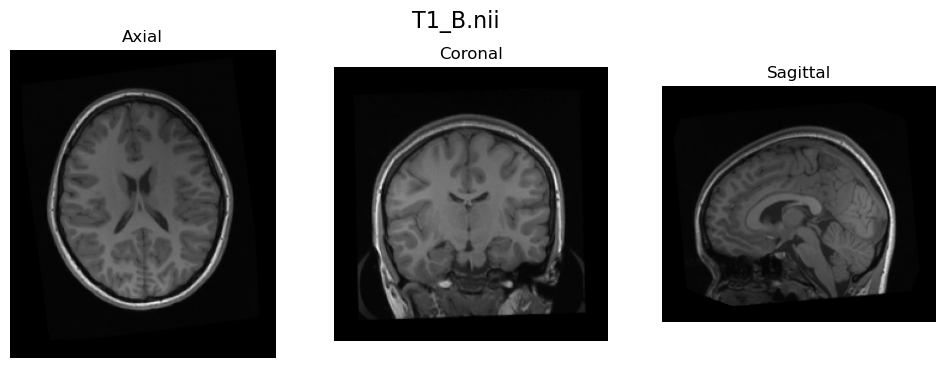

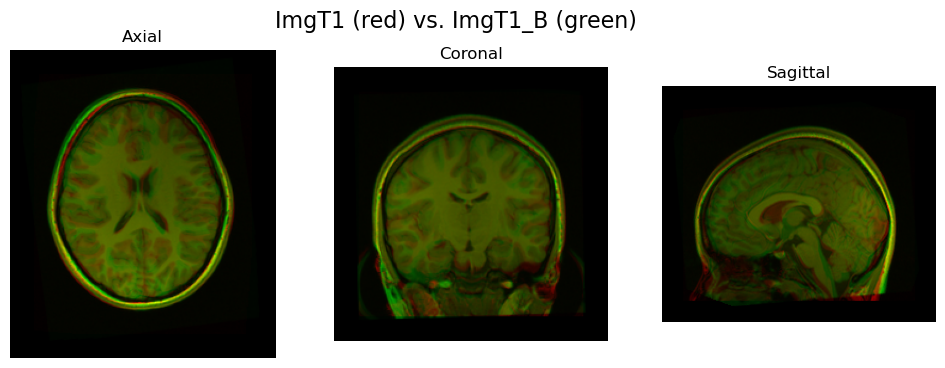

In [36]:
imshow_orthogonal_view(ImgT1_B, title='T1_B.nii')
overlay_slices(fixed_image, ImgT1_B, title = 'ImgT1 (red) vs. ImgT1_B (green)')

### Exercise 7 - Change the rotation center to the center of the fixed image
By default, SimpleITK uses the fixed image’s origin as the rotation center. Change the rotation center to the center of the fixed image and repeat the registration. Compare the results.

Change the rotation center to the center of the image using the following code and repeating the registration (Exercise 5):

In [48]:
fixed_image = sitk.ReadImage(dir_in + 'ImgT1.nii')
moving_image = sitk.ReadImage(dir_in + 'ImgT1_A.nii')

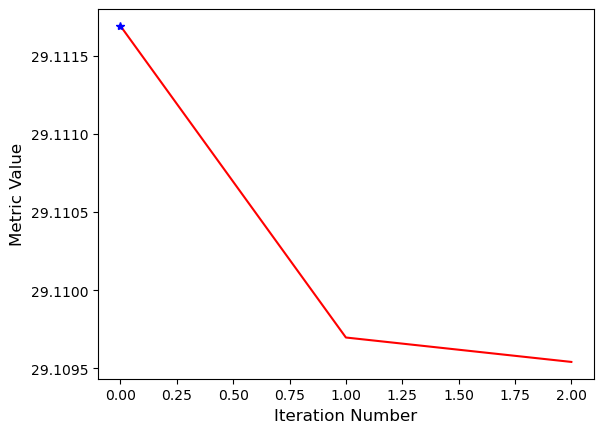

In [49]:
# Set the registration - Fig. 1 from the Theory Note
R = sitk.ImageRegistrationMethod()

# Set a one-level the pyramid scheule. [Pyramid step]
R.SetShrinkFactorsPerLevel(shrinkFactors = [2])
R.SetSmoothingSigmasPerLevel(smoothingSigmas=[0])
R.SmoothingSigmasAreSpecifiedInPhysicalUnitsOn()

# Set the interpolator [Interpolation step]
R.SetInterpolator(sitk.sitkLinear)

# Set the similarity metric [Metric step]
R.SetMetricAsMeanSquares()

# Set the sampling strategy [Sampling step]
R.SetMetricSamplingStrategy(R.RANDOM)
R.SetMetricSamplingPercentage(0.50)

# Set the optimizer [Optimization step]
R.SetOptimizerAsPowell(stepLength=0.1, numberOfIterations=25)

# Initialize the transformation type to rigid 
initTransform = sitk.CenteredTransformInitializer(fixed_image, moving_image, sitk.Euler3DTransform(), sitk.CenteredTransformInitializerFilter.GEOMETRY)
R.SetInitialTransform(initTransform, inPlace=False)

# Some extra functions to keep track to the optimization process 
# R.AddCommand(sitk.sitkIterationEvent, lambda: command_iteration(R)) # Print the iteration number and metric value
R.AddCommand(sitk.sitkStartEvent, start_plot) # Plot the similarity metric values across iterations
R.AddCommand(sitk.sitkEndEvent, end_plot)
R.AddCommand(sitk.sitkMultiResolutionIterationEvent, update_multires_iterations) 
R.AddCommand(sitk.sitkIterationEvent, lambda: plot_values(R))

# Estimate the registration transformation [metric, optimizer, transform]
tform_reg = R.Execute(fixed_image, moving_image)

# Apply the estimated transformation to the moving image
ImgT1_B_center = sitk.Resample(moving_image, tform_reg)


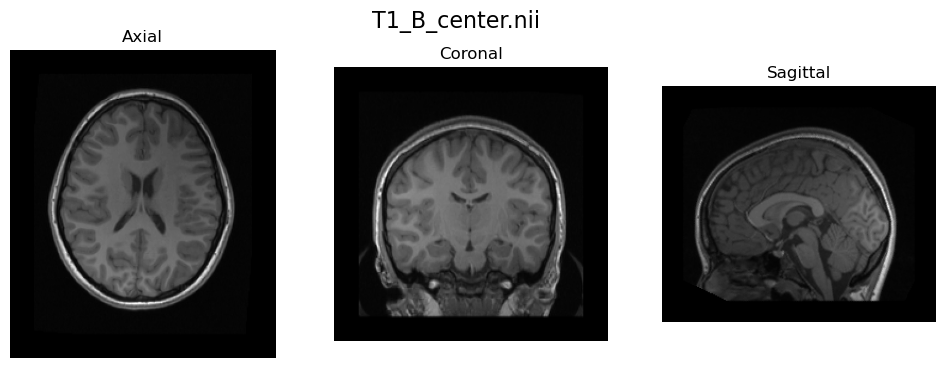

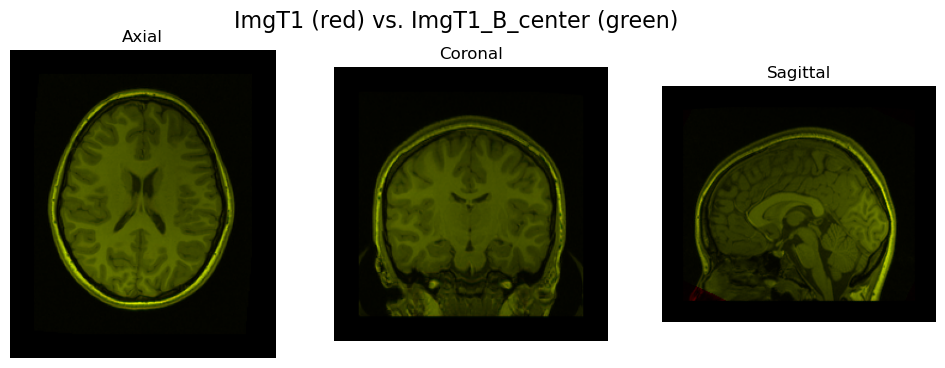

In [50]:
imshow_orthogonal_view(ImgT1_B_center, title='T1_B_center.nii')
overlay_slices(fixed_image, ImgT1_B_center, title = 'ImgT1 (red) vs. ImgT1_B_center (green)')

In [51]:
matrix_estimated = homogeneous_matrix_from_transform(tform_reg.GetNthTransform(0))
matrix_applied = homogeneous_matrix_from_transform(transform)

print('Applied transformation matrix: ')
print(np.round(matrix_applied, 2))
print('Estimated registration matrix: ')
print(np.round(matrix_estimated, 2))

# We expect the estimated matrix to be close to the inverse of the actual matrix
print('Estimated @ Actual: ')
print(np.round(matrix_applied @ matrix_estimated, 2)) # Should be identity matrix

# We can also check the individual components of the estimated matrix
print(' ')
params = tform_reg.GetParameters()
angles = params[:3]
trans = params[3:6]
print('Estimated translation: ')
print(np.round(trans, 2))
print('Estimated rotation (deg): ')
print(np.round(np.rad2deg(angles), 2))

Applied transformation matrix: 
[[ 1.    0.    0.    0.  ]
 [ 0.    0.91  0.42  0.  ]
 [ 0.   -0.42  0.91  0.  ]
 [ 0.    0.    0.    1.  ]]
Estimated registration matrix: 
[[ 1.    0.   -0.   -0.  ]
 [-0.    0.91 -0.42  0.  ]
 [ 0.    0.42  0.91 -0.  ]
 [ 0.    0.    0.    1.  ]]
Estimated @ Actual: 
[[ 1.  0. -0. -0.]
 [-0.  1.  0.  0.]
 [ 0. -0.  1. -0.]
 [ 0.  0.  0.  1.]]
 
Estimated translation: 
[-0.  0. -0.]
Estimated rotation (deg): 
[25. -0. -0.]


## Generate a series of rotated 3D images


**Exercise 8** 
Make four rotation matrices that rotate the ImgT1nii in steps of 60 degrees starting from 60 degrees. Apply the rotation to ImgT1.nii, reslice and store the resulting images as ImgT1_60.nii, ImgT1_120.nii etc. Show in ortho-view that the rotations are applied as expected for each new image.

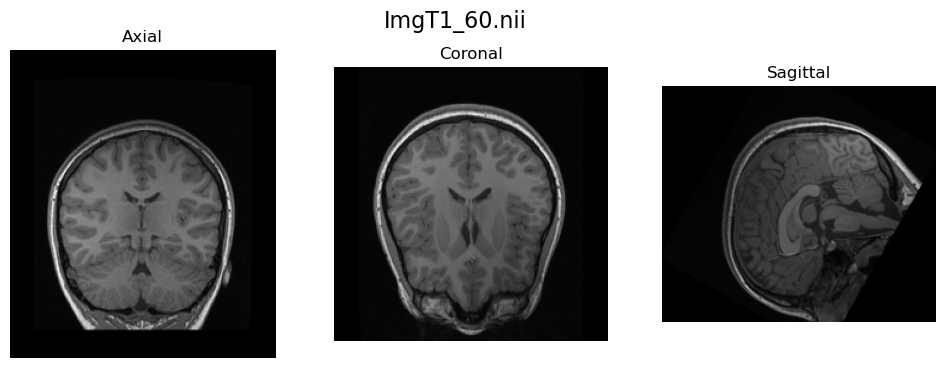

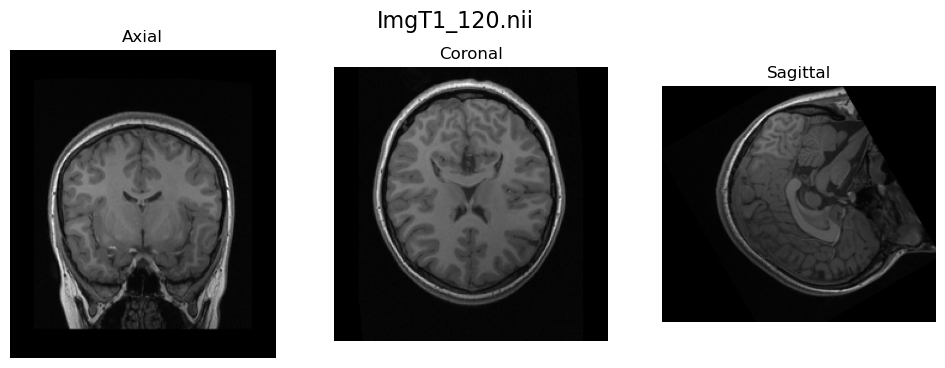

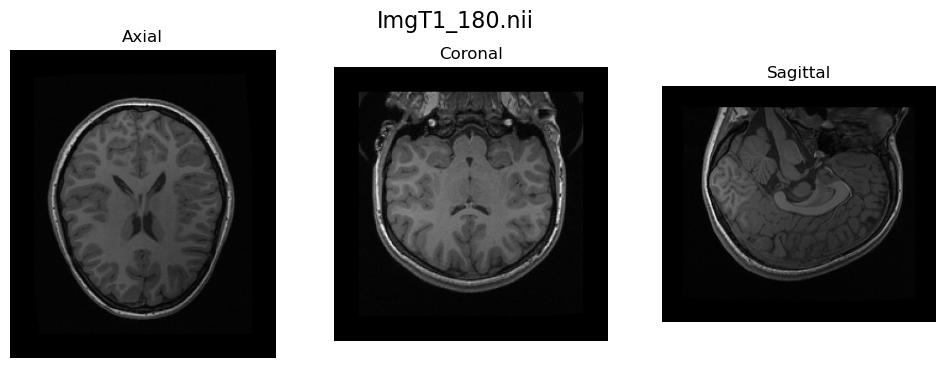

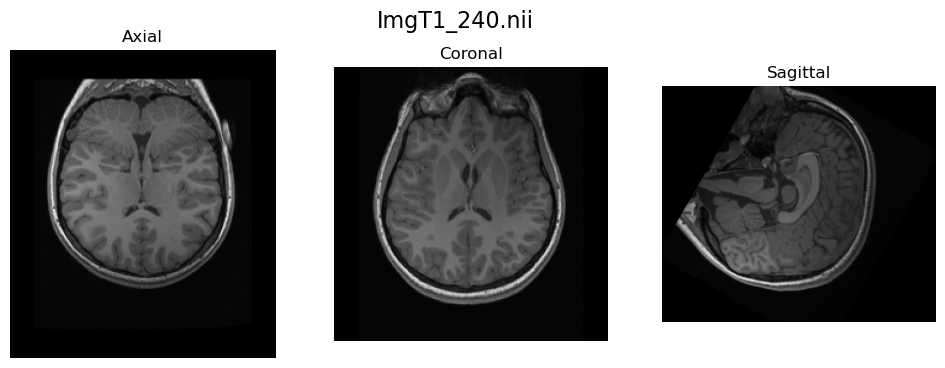

In [52]:
pitch_buffer = np.arange(1, 5)*60

for i, angle in enumerate(pitch_buffer):
    # Define the roll rotation in radians
    pitch_radians = np.deg2rad(angle)

    # Create the Affine transform and set the rotation
    transform = sitk.AffineTransform(3)

    centre_image = np.array(vol_sitk.GetSize()) / 2 - 0.5 # Image Coordinate System
    centre_world = vol_sitk.TransformContinuousIndexToPhysicalPoint(centre_image) # World Coordinate System
    rot_matrix = rotation_matrix(pitch_radians, 0, 0)[:3, :3] # SimpleITK inputs the rotation and the translation separately

    transform.SetCenter(centre_world) # Set the rotation centre
    transform.SetMatrix(rot_matrix.T.flatten())

    # Apply the transformation to the image
    output = sitk.Resample(vol_sitk, transform)

    # Visualize the rotated image
    imshow_orthogonal_view(output, title=f'ImgT1_{angle}.nii')
    
    # Save the rotated image
    sitk.WriteImage(output, f'{dir_in}ImgT1_{angle}.nii')

### Exercise 9
Use ImgT1_120.nii as the fixed image, and the other three rotated images from Exercise 8 as the moving images. Run the registration to find the affine matrix and include the reslicing procedure for each of the moving images. Show in ortho-view the resliced images and describe what the rotation angles are. Save the transforms with the name "Ex9_60.tfm, Ex10_180.tfm, Ex10_240.tfm" Do the rotations agree with those in Exercise 8?

  0 =   12.32932 : (-2.0943436543737177, 3.7915306895891436e-05, -2.7844341408542765e-06, 0.0010473976520774773, -0.0010914768319768909, 0.000818897688381008)
  1 =   12.32918 : (-1.0471740107432168, 3.136650923221094e-06, 3.1950155210925656e-06, 0.0008598744125697471, -0.0006706289494479539, 0.00045922946573363467)
  2 =   12.32916 : (-1.0471729189650378, 1.0935848753586855e-05, 5.209397241771857e-06, 0.0007942419662593631, -0.0005920985542747084, 0.0004333504962797197)
  3 =   12.32914 : (-1.0471715401621389, 1.6179299265283296e-05, 1.1371418555018407e-05, 0.0008694663229716618, -0.0006756815762154641, 0.0004319363508114726)
Estimated rotation (deg) for ImgT1_60.nii: 
[-5.9999e+01  1.0000e-03  1.0000e-03]
 
  0 =   29.76897 : (64.92627650365999, -1.6608028522778328e-05, -4.161482144147228e-05, 0.0013618459429643663, -0.0029369822794637203, -0.00466912332577936)
  1 =   29.76778 : (32.46311737665285, -6.894058268066916e-06, -2.4717943242829777e-05, 0.0006408751301750477, -0.0019330199

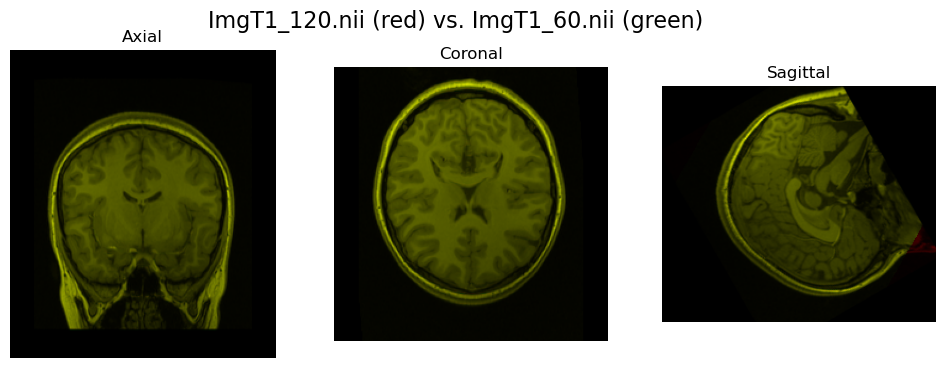

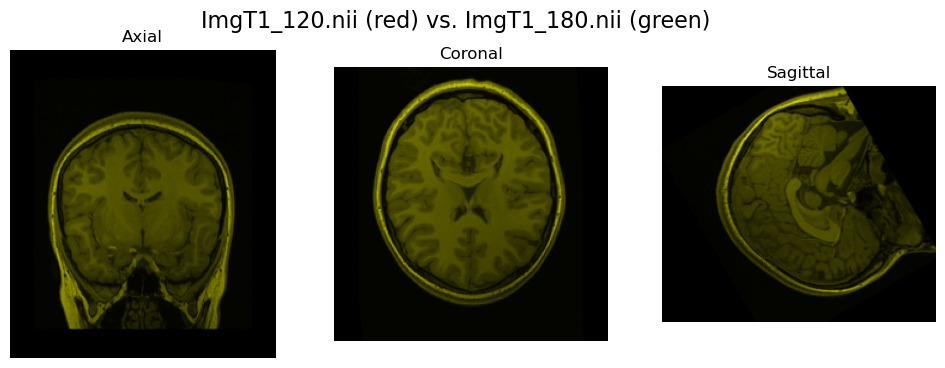

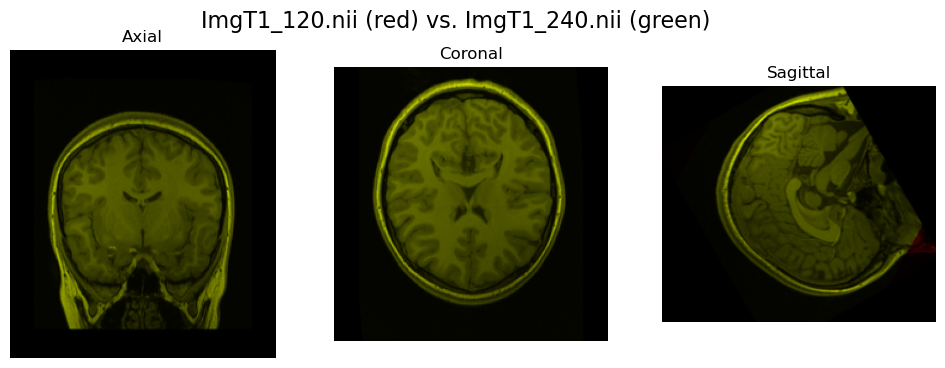

In [54]:
# Set the registration method
R = sitk.ImageRegistrationMethod()
# Set the metric
R.SetMetricAsMeanSquares()

# Set the optimizer
R.SetOptimizerAsPowell(stepLength=20, numberOfIterations=25)

# Set the sampling strategy
R.SetMetricSamplingStrategy(R.RANDOM)
R.SetMetricSamplingPercentage(0.20)

# Set the pyramid scheule
R.SetShrinkFactorsPerLevel(shrinkFactors = [2])
R.SetSmoothingSigmasPerLevel(smoothingSigmas=[0])
R.SmoothingSigmasAreSpecifiedInPhysicalUnitsOn()

# Set the initial transform
R.SetInterpolator(sitk.sitkLinear)

# Some extra functions to help with the iteration - Instead of a plot, we print
#  iter = metric value : (Rx, Ry, Rz, Tx, Ty, Tz)
R.AddCommand(sitk.sitkIterationEvent, lambda: command_iteration(R))

fixed_image = sitk.ReadImage(dir_in + 'ImgT1_120.nii')
pitch_buffer = np.array([60, 180, 240])
for i, angle in enumerate(pitch_buffer):
    
    moving_image = sitk.ReadImage(dir_in + f'ImgT1_{angle}.nii')

    # Set the initial transform 
    initTransform =sitk.CenteredTransformInitializer(fixed_image, moving_image, sitk.Euler3DTransform(), sitk.CenteredTransformInitializerFilter.GEOMETRY)
    R.SetInitialTransform(initTransform, inPlace=False)

    # Execute the registration
    tform_reg = R.Execute(fixed_image, moving_image)
    tform_reg.WriteTransform(dir_in + f'Ex9_{angle}.tfm')

    params = tform_reg.GetParameters()
    angles = params[:3]
    print(f'Estimated rotation (deg) for ImgT1_{angle}.nii: ')
    print(np.round(np.rad2deg(angles), 3))
    print(' ')

    img_tmp = sitk.Resample(moving_image, tform_reg)
    # imshow_orthogonal_view(img_tmp, title=f'Registered ImgT1_{angle}.nii to ImgT1_120.nii')
    overlay_slices(fixed_image, img_tmp, title=f'ImgT1_120.nii (red) vs. ImgT1_{angle}.nii (green)')

## Registration of a series of 3D images

### Exercise 10
Use the ImgT1_240.nii as the fixed image and use the ImgT1.nii as the moving image. Make an affine matrix clockwise by combining the estimated transformation and the affine matrix obtained at each rotation step in exercise 10 and apply reslicing. Show in ortho views that the ImgT1.nii after applying the combined affine matrix is registered as expected. Show the combined affine matrix and explains if it applies the expected rotation angle.

  0 = 13615.90228 : (6.209415595303473e-05, 6.380764148934132e-05, 0.0, -0.0012779018072498346, 32.040233053490844, -29.58205804196734)
  1 = 10472.21653 : (-9.858880601573453, 3.190382074467066e-05, -0.00018087492268272076, -0.0017503197261283091, 13.272564431717736, -0.2859727167800017)
  2 = 8708.56126 : (-17.21636340560004, 0.00010572016736013492, -2.7411174088255055e-05, -0.3750601778688313, 11.067609781178618, -7.538496678710831)
  3 = 5981.59676 : (-23.248013179839305, 0.008451445005639258, -6.931281803842457e-05, -0.1583327547195032, 6.667637710141745, -1.220669131762119)
  4 = 4480.26587 : (-29.141656674335444, 0.011628504496017326, -7.43848626003443e-05, -0.04811266671964606, 0.06677845517858749, 1.8413717464474315)
  5 = 1236.03493 : (-23.04197392464223, -0.011221357322497428, -0.00598680189824791, -0.05113475514772127, 0.46374397228825526, -1.3276724493747787)
  6 =  946.57690 : (-22.95284308105806, 0.005574398016271984, -0.00846480441987928, -0.03415644095454713, -3.011520

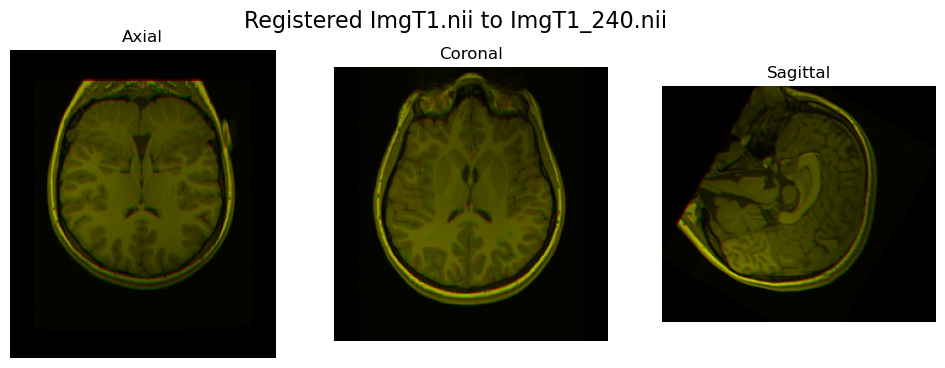

In [63]:
fixed_image = sitk.ReadImage(dir_in + 'ImgT1_240.nii')
moving_image = sitk.ReadImage(dir_in + 'ImgT1.nii')

# Set the registration method
R = sitk.ImageRegistrationMethod()
# Set the metric
R.SetMetricAsMeanSquares()

# Set the optimizer
R.SetOptimizerAsPowell(stepLength=10, numberOfIterations=25)

# Set the pyramid scheule
R.SetShrinkFactorsPerLevel(shrinkFactors = [2])
R.SetSmoothingSigmasPerLevel(smoothingSigmas=[0])
R.SmoothingSigmasAreSpecifiedInPhysicalUnitsOn()

# Set the sampling strategy
R.SetMetricSamplingStrategy(R.RANDOM)
R.SetMetricSamplingPercentage(0.20)

# Set the initial transform
R.SetInterpolator(sitk.sitkLinear)

# Some extra functions to help with the iteration
R.AddCommand(sitk.sitkIterationEvent, lambda: command_iteration(R))

# Set the initial transform 
initTransform =sitk.CenteredTransformInitializer(fixed_image, moving_image, sitk.Euler3DTransform(), sitk.CenteredTransformInitializerFilter.GEOMETRY)
R.SetInitialTransform(initTransform, inPlace=False)

# Execute the registration
tform_reg = R.Execute(fixed_image, moving_image)
tform_reg.WriteTransform(dir_in + 'Ex10_0.tfm')

params = tform_reg.GetParameters()
angles = params[:3]
print('Estimated rotation (deg) for ImgT1.nii: ')
print(np.round(np.rad2deg(angles), 3))

img_tmp = sitk.Resample(moving_image, tform_reg)
# imshow_orthogonal_view(img_tmp, title='Registered ImgT1.nii to ImgT1_240.nii')
overlay_slices(fixed_image, img_tmp, title='Registered ImgT1.nii to ImgT1_240.nii')

In [64]:
params = tform_reg.GetParameters()
angles = params[:3]
print(f'Estimated rotation (deg): ')
print(np.round(np.rad2deg(angles), 2))

Estimated rotation (deg): 
[-1.32025e+03 -1.20000e-01  1.20000e-01]


In [65]:
# Load the transforms from file
moving_image = sitk.ReadImage(dir_in + 'ImgT1.nii')

tform_60 = sitk.ReadTransform(dir_in + 'Ex9_60.tfm')
tform_180 = sitk.ReadTransform(dir_in + 'Ex9_180.tfm')
tform_240 = sitk.ReadTransform(dir_in + 'Ex9_240.tfm')
tform_0 = sitk.ReadTransform(dir_in + 'Ex10_0.tfm')

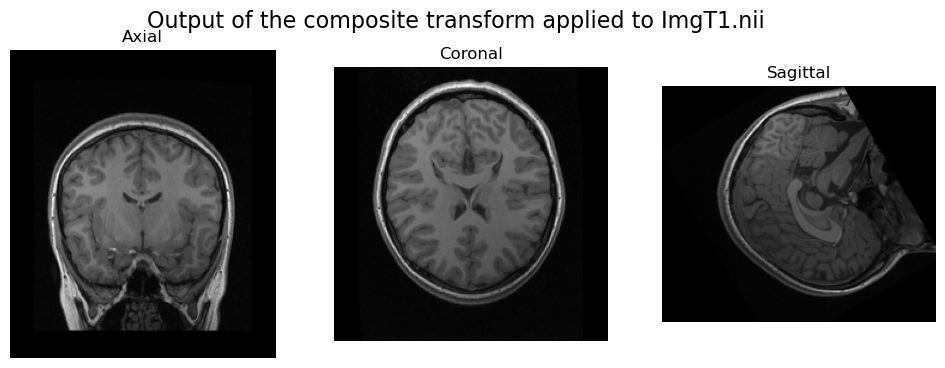

In [66]:
# Option A: Combine the transforms using the sitk.CompositeTransform(3) function
# Concatenate - The last added transform is applied first
tform_composite = sitk.CompositeTransform(3)

tform_composite.AddTransform(tform_240.GetNthTransform(0)) 
tform_composite.AddTransform(tform_180.GetNthTransform(0))
tform_composite.AddTransform(tform_60.GetNthTransform(0))
tform_composite.AddTransform(tform_0.GetNthTransform(0))
# Transform the composite transform to an affine transform
affine_composite = composite2affine(tform_composite, centre_world)

img_tmp = sitk.Resample(moving_image, tform_composite)
imshow_orthogonal_view(img_tmp, title='Output of the composite transform applied to ImgT1.nii')


In [67]:
# Since we are using just Euler transformations, we can map it to a rigid transform
euler_composite = sitk.Euler3DTransform()
euler_composite.SetMatrix(affine_composite.GetMatrix())
euler_composite.SetTranslation(affine_composite.GetTranslation())
euler_composite.SetCenter(affine_composite.GetCenter())

params = euler_composite.GetParameters()
angles = params[:3]

print(f'Estimated rotation (deg) for the composite transformation: ')
print(np.round(np.rad2deg(angles), 2))

print(f'Estimated homogeneous matrix: ')
print(np.round(homogeneous_matrix_from_transform(euler_composite),2))

Estimated rotation (deg) for the composite transformation: 
[ -59.75 -179.92 -179.88]
Estimated homogeneous matrix: 
[[ 1.    0.   -0.    0.02]
 [ 0.   -0.5   0.86  1.06]
 [ 0.   -0.86 -0.5   0.82]
 [ 0.    0.    0.    1.  ]]


## Robustness in the registration and number of iterations

### Exercise 11
Use the ImgT1.nii as the fixed image and ImgT1_240.nii as the moving image. Increase the noise level of the moving image and register it to the fixed image and repeat the registration at the same noise-level for different step length. For what standard deviation level and step length does the optimization algorithm cannot find the global minimum? Show the ortho-views of the noisy moving image.


  0 = 11898.44669 : (20.9419904053381, -0.00022878444072223488, 0.0, -0.006936694989788296, -0.07273552058544726, -0.05658067175320924)
  1 = 11898.27115 : (10.47099520266905, -0.00011439222036111744, 0.0, -0.0023771975405908817, -0.03895803775814526, -0.01462142754587557)
  2 = 11897.81377 : (10.471130148244514, -0.00011439222036111744, 7.114001250326787e-06, -0.0027419972502782846, -0.0376269307279109, -0.02122985460363849)
Estimated rotation (deg) for ImgT1_240.nii (noisy): 
[ 5.99952e+02 -7.00000e-03  0.00000e+00]


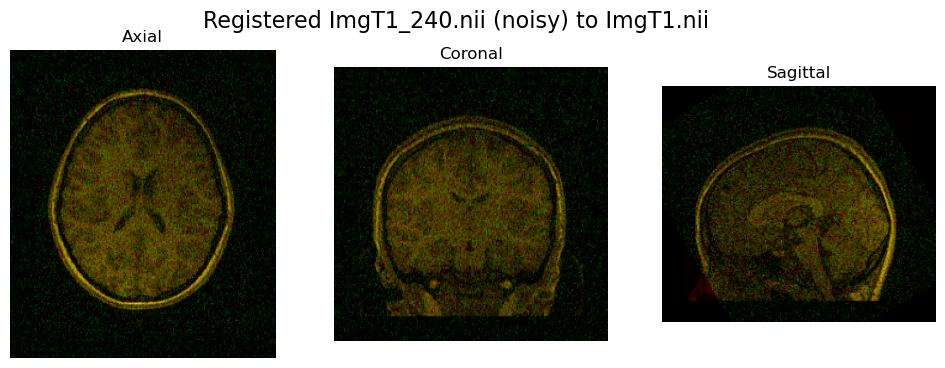

In [68]:
fixed_image = sitk.ReadImage(dir_in + 'ImgT1.nii')
moving_image = sitk.ReadImage(dir_in + 'ImgT1_240.nii')
moving_image_noisy = sitk.AdditiveGaussianNoise(moving_image, mean=0, standardDeviation=200)

# Set the registration method
R = sitk.ImageRegistrationMethod()
# Set the metric
R.SetMetricAsMeanSquares()

# Set the optimizer
R.SetOptimizerAsPowell(stepLength=10, numberOfIterations=25)

# Set the pyramid scheule
R.SetShrinkFactorsPerLevel(shrinkFactors = [2])
R.SetSmoothingSigmasPerLevel(smoothingSigmas=[0])
R.SmoothingSigmasAreSpecifiedInPhysicalUnitsOn()

# Set the sampling strategy
R.SetMetricSamplingStrategy(R.RANDOM)
R.SetMetricSamplingPercentage(0.20)

# Set the initial transform
R.SetInterpolator(sitk.sitkLinear)

# Some extra functions to help with the iteration
R.AddCommand(sitk.sitkIterationEvent, lambda: command_iteration(R))

# Set the initial transform 
initTransform =sitk.CenteredTransformInitializer(fixed_image, moving_image_noisy, sitk.Euler3DTransform(), sitk.CenteredTransformInitializerFilter.GEOMETRY)
R.SetInitialTransform(initTransform, inPlace=False)

# Execute the registration
tform_reg = R.Execute(fixed_image, moving_image_noisy)
tform_reg.WriteTransform(dir_in + 'ImgT1_240_noisy.tfm')

params = tform_reg.GetParameters()
angles = params[:3]
print('Estimated rotation (deg) for ImgT1_240.nii (noisy): ')
print(np.round(np.rad2deg(angles), 3))

img_tmp = sitk.Resample(moving_image_noisy, tform_reg)
# imshow_orthogonal_view(img_tmp, title='Registered ImgT1.nii to ImgT1_240.nii')
overlay_slices(fixed_image, img_tmp, title='Registered ImgT1_240.nii (noisy) to ImgT1.nii')

In [69]:
matrix_estimated = homogeneous_matrix_from_transform(tform_reg.GetNthTransform(0))
matrix_applied = homogeneous_matrix_from_transform(transform)

print('Applied transformation matrix: ')
print(np.round(matrix_applied, 2))
print('Estimated registration matrix: ')
print(np.round(matrix_estimated, 2))

# We expect the estimated matrix to be close to the inverse of the actual matrix
print('Estimated @ Actual: ')
print(np.round(matrix_applied @ matrix_estimated, 2)) # Should be identity matrix

# We can also check the individual components of the estimated matrix
print(' ')
params = tform_reg.GetParameters()
angles = params[:3]
trans = params[3:6]
print('Estimated translation: ')
print(np.round(trans, 2))
print('Estimated rotation (deg): ')
print(np.round(np.rad2deg(angles), 2))

Applied transformation matrix: 
[[ 1.    0.    0.    0.  ]
 [ 0.   -0.5  -0.87  0.  ]
 [ 0.    0.87 -0.5   0.  ]
 [ 0.    0.    0.    1.  ]]
Estimated registration matrix: 
[[ 1.    0.   -0.   -0.  ]
 [ 0.   -0.5   0.87 -0.04]
 [-0.   -0.87 -0.5  -0.02]
 [ 0.    0.    0.    1.  ]]
Estimated @ Actual: 
[[ 1.    0.   -0.   -0.  ]
 [-0.    1.    0.    0.04]
 [ 0.   -0.    1.   -0.02]
 [ 0.    0.    0.    1.  ]]
 
Estimated translation: 
[-0.   -0.04 -0.02]
Estimated rotation (deg): 
[ 5.9995e+02 -1.0000e-02  0.0000e+00]


### Exercise 12
Register the noisy moving image using the pyramidal procedure. Try three levels of setting sigma=[3.0, 1.0, 0.0]. Repeat the registration procedure with different step lengths. Does the image registration become more insensitive to the step length? If not try increasing sigma=[5.0, 1.0, 0.0]. Can one use only 2 levels of the pyramid? What do you suggest of sigma values? Show the optimal affine matrices for each of the repeats to check robustness.

  0 =   36.21581 : (20.944160580418348, -0.00044978284302668706, -1.0405694817049634e-05, 0.00038259759875676746, -0.01021976293861097, 0.005785374064269523)
  1 =   36.21564 : (10.472001530089639, -0.00022489142151334353, -5.202847408524817e-06, 0.00019299254708792063, -0.007942833371207759, 0.002870918952177271)
  0 =  736.98372 : (10.472367039814444, -0.00022489142151334353, -5.202847408524817e-06, -0.0038969762319810684, 0.015991520914629236, -0.01036759573027885)
  1 =  736.98154 : (10.47219782888161, -0.00026839589983542497, -3.7739704693584526e-06, -0.0030286890246182647, 0.0072181385285080574, -0.004385998946015658)
  0 = 11919.30753 : (10.472292529239324, 0.001114369932468323, 5.238354452131041e-05, 0.03143766914599539, 0.013161499508176239, -0.012155970001685163)
  1 = 11899.10395 : (10.469007297295125, 0.0011903768986005524, -0.005531419582774973, 0.10927404613665823, -0.15908042771216202, -0.014549432094505765)
  2 = 11894.33179 : (10.470621879743486, 0.0011523538963563124,

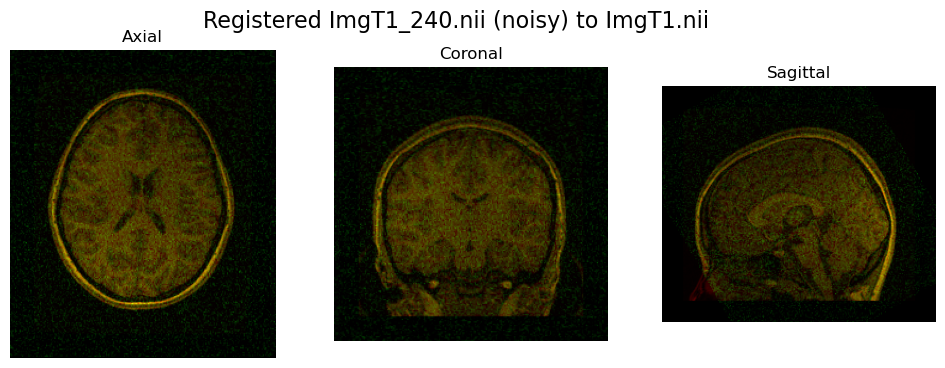

In [70]:
fixed_image = sitk.ReadImage(dir_in + 'ImgT1.nii')
moving_image = sitk.ReadImage(dir_in + 'ImgT1_240.nii')
moving_image_noisy = sitk.AdditiveGaussianNoise(moving_image, mean=0, standardDeviation=200)

# Set the registration method
R = sitk.ImageRegistrationMethod()
# Set the metric
R.SetMetricAsMeanSquares()

# Set the optimizer
R.SetOptimizerAsPowell(stepLength=10, numberOfIterations=25)

# Set the pyramid scheule
R.SetShrinkFactorsPerLevel(shrinkFactors = [2,2,2])
R.SetSmoothingSigmasPerLevel(smoothingSigmas=[3,1,0])
R.SmoothingSigmasAreSpecifiedInPhysicalUnitsOn()

# Set the sampling strategy
R.SetMetricSamplingStrategy(R.RANDOM)
R.SetMetricSamplingPercentage(0.20)

# Set the initial transform
R.SetInterpolator(sitk.sitkLinear)

# Some extra functions to help with the iteration
R.AddCommand(sitk.sitkIterationEvent, lambda: command_iteration(R))

# Set the initial transform 
initTransform =sitk.CenteredTransformInitializer(fixed_image, moving_image_noisy, sitk.Euler3DTransform(), sitk.CenteredTransformInitializerFilter.GEOMETRY)
R.SetInitialTransform(initTransform, inPlace=False)

# Execute the registration
tform_reg = R.Execute(fixed_image, moving_image_noisy)
tform_reg.WriteTransform(dir_in + 'ImgT1_240_noisy.tfm')

params = tform_reg.GetParameters()
angles = params[:3]
print('Estimated rotation (deg) for ImgT1_240.nii (noisy): ')
print(np.round(np.rad2deg(angles), 3))

img_tmp = sitk.Resample(moving_image_noisy, tform_reg)
# imshow_orthogonal_view(img_tmp, title='Registered ImgT1.nii to ImgT1_240.nii')
overlay_slices(fixed_image, img_tmp, title='Registered ImgT1_240.nii (noisy) to ImgT1.nii')

## Lecture 12

Voxel: volume pixel

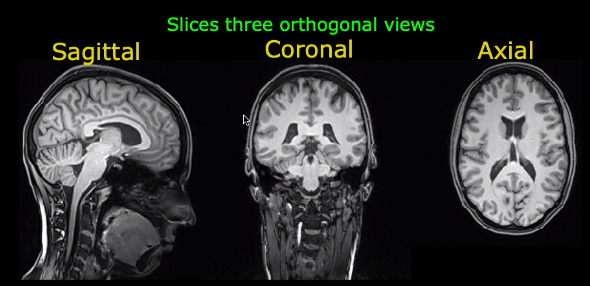

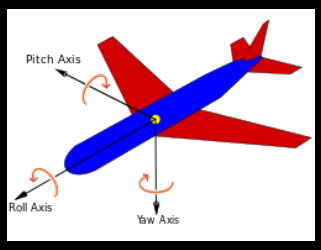

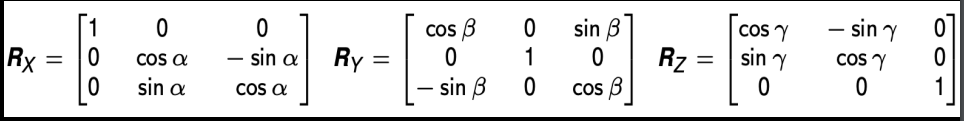

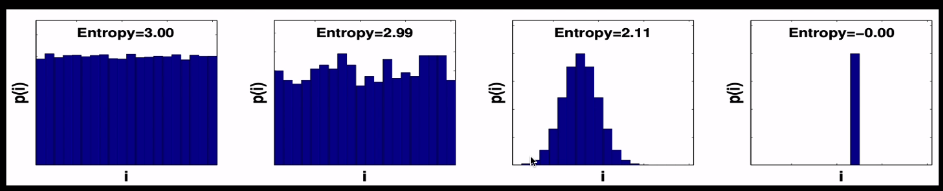

### Entropy
 
$H =- \sum_i p_i log_b p_i$

In [9]:
# What is the entropy of?
green = 13
pink = 14
total = green + pink

p_green = green / total
p_pink = pink / total

entropy = -p_green * np.log2(p_green) - p_pink * np.log2(p_pink)
print('Entropy:', entropy)


Entropy: 0.9990102708804813


### Exercise: Gradient descent
Model fitting uses a cost function: $C(x) = x_1^2 + x_1 x_2 + 3 x_2^2$
and an iterative optimizer Gradient descent with a step length of 0.2
What is the new position of xnew =[?,?]T after one step from position x=[1, 0]T?

In [13]:
x = np.array([1,0]).T
step_length = 0.2

x1, x2 = 1, 0
y_prime = [2*x1 + x2,x1+6*x2]
print('y_prime:', np.array(y_prime))

xnew = np.array(x).T-step_length*np.array(y_prime).T
print('x_new:', xnew)

y_prime: [2 1]
x_new: [ 0.6 -0.2]


### Feature value
Plus grey, minus white areas

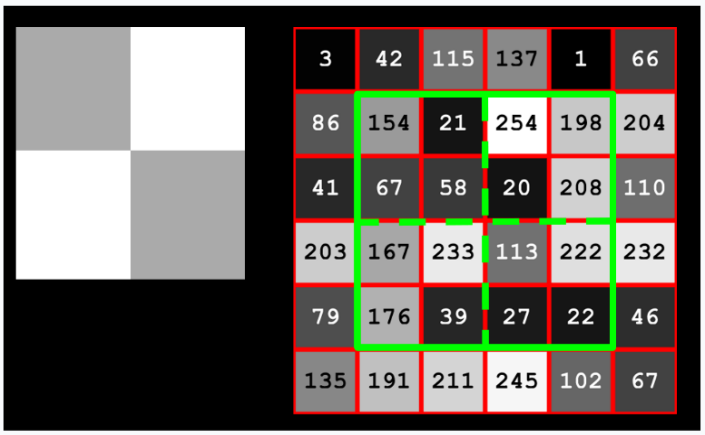

In [14]:
v = 154+21+67+58+113+222+27+22-254-198-20-208-167-233-176-39
print('The feature value is', v)

The feature value is -611


15 basic operations are needed to compute 16 numbers

### Integral image
In an integral image the pixel value is:
* The sum of pixel above it and to the left of it in the original image
* Including the pixel itself

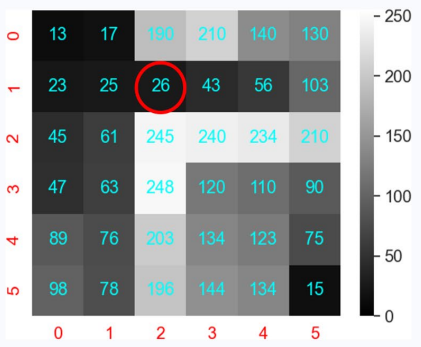

In [16]:
13+17+190+23+25+26

294